# Spatial Analysis & Propensity Score Matching (CCI Projects)

This notebook performs a spatial and collaborative analysis of CCI projects using propensity score matching to assess the impact of high-collaboration efforts on GHG efficiency and equity.

In [1]:
# Imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# Load and clean data
df = pd.read_csv('cci_programs_data_reduced.csv', low_memory=False)
df = df.rename(columns={'Agency Name': 'Agency_Name', 'County': 'County'})

df['Total Program GGRFFunding'] = pd.to_numeric(df['Total Program GGRFFunding'], errors='coerce')
df['Total Project GHGReductions'] = pd.to_numeric(df['Total Project GHGReductions'], errors='coerce')
df['Total GGRFDisadvantaged Community Funding'] = pd.to_numeric(df['Total GGRFDisadvantaged Community Funding'], errors='coerce')

df['cost_per_ton'] = df['Total Program GGRFFunding'] / df['Total Project GHGReductions']
df['share_DAC'] = df['Total GGRFDisadvantaged Community Funding'] / df['Total Program GGRFFunding']
df['log_funding'] = np.log1p(df['Total Program GGRFFunding'])


In [9]:
# Aggregate project-level data
project_df = df.groupby('Project ID Number').agg({
    'log_funding': 'first',
    'Agency_Name': 'first',
    'County': 'first',
    'cost_per_ton': 'first',
    'share_DAC': 'first'
}).reset_index()

# Add region and collaboration features
project_df['n_partners'] = df.groupby('Project ID Number')['County'].nunique().values
project_df['high_collab'] = (project_df['n_partners'] > 5).astype(int)

south_counties = ["Los Angeles", "Orange", "San Diego", "Riverside", "San Bernardino", "Imperial", "Ventura"]
project_df['Region_South'] = project_df['County'].isin(south_counties).astype(int)

# Drop rows with missing data in modeling variables
project_df = project_df.dropna(subset=['log_funding', 'Agency_Name', 'Region_South', 'high_collab'])


In [10]:
# Build covariate matrix for PSM
covariates = ['log_funding', 'Agency_Name', 'Region_South']
X = pd.get_dummies(project_df[covariates], drop_first=True).astype(float)
y = project_df['high_collab'].astype(int)

# Fit logistic regression (PSM)
ps_model = sm.Logit(y, sm.add_constant(X)).fit(method='lbfgs', maxiter=500, disp=0)
project_df['propensity'] = ps_model.predict(sm.add_constant(X))


/Users/dpadams/Repos/new_california_equity/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [5]:
# Perform nearest neighbor matching
treated = project_df[project_df['high_collab'] == 1]
control = project_df[project_df['high_collab'] == 0]

matches = []
for idx, p in treated['propensity'].items():
    closest_idx = (control['propensity'] - p).abs().idxmin()
    matches.append((idx, closest_idx))

matched_idx = [i for pair in matches for i in pair]
matched_sample = project_df.loc[matched_idx]


In [6]:
# Clean out extreme or invalid values
matched_sample = matched_sample.replace([np.inf, -np.inf], np.nan).dropna(subset=['cost_per_ton', 'share_DAC'])

matched_treated = matched_sample[matched_sample['high_collab'] == 1]
matched_control = matched_sample[matched_sample['high_collab'] == 0]

# Summary statistics
print("High-collab avg $/ton:", matched_treated['cost_per_ton'].mean())
print("Low-collab avg $/ton:", matched_control['cost_per_ton'].mean())
print("High-collab avg share_DAC:", matched_treated['share_DAC'].mean())
print("Low-collab avg share_DAC:", matched_control['share_DAC'].mean())


High-collab avg $/ton: 544.4898966105618
Low-collab avg $/ton: 7262.068465753554
High-collab avg share_DAC: 0.7419354838709677
Low-collab avg share_DAC: 0.42857142857142855


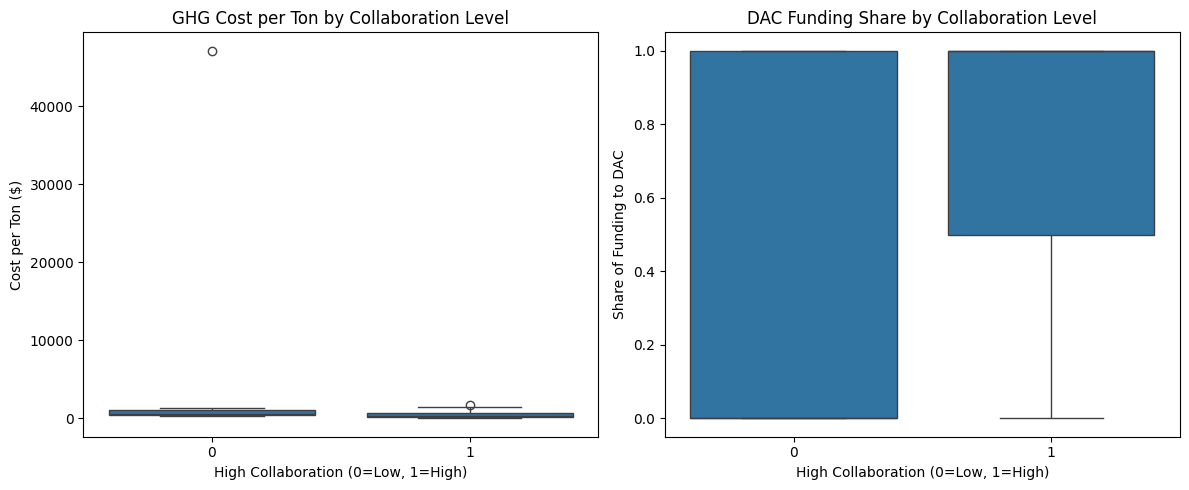

In [7]:
# Plot comparisons
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x='high_collab', y='cost_per_ton', data=matched_sample, ax=axs[0])
axs[0].set_title('GHG Cost per Ton by Collaboration Level')
axs[0].set_xlabel('High Collaboration (0=Low, 1=High)')
axs[0].set_ylabel('Cost per Ton ($)')

sns.boxplot(x='high_collab', y='share_DAC', data=matched_sample, ax=axs[1])
axs[1].set_title('DAC Funding Share by Collaboration Level')
axs[1].set_xlabel('High Collaboration (0=Low, 1=High)')
axs[1].set_ylabel('Share of Funding to DAC')

plt.tight_layout()
plt.show()
